In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import pickle
import seaborn as sns

sys.path.append('..')

import warnings
warnings.filterwarnings("ignore")

In [3]:
from simulations.dummy_scenarios import *
from scripts.parse_enron import Message

In [4]:
sns.set_context("paper", font_scale=1.5)
sns.set_style("white")
sns.set_palette('colorblind', n_colors=4)

In [5]:
parsed_logs_folder = '../Enron/parsing/'
social_graph = pickle.load(open(parsed_logs_folder + "social.pkl", "rb"))
log = pickle.load(open(parsed_logs_folder + "replay_log.pkl", "rb"))

In [6]:
context = Context(log, social_graph)

In [7]:
def visualize_propagation(scenario_name, kp, hp=None):
    kp = kp[['Stale', 'Updated']]
    
    kp.plot.area()
    plt.legend(frameon=True)
    plt.title("%s — Encryption keys propagation" % scenario_name)
    plt.xlabel("Emails sent")
    plt.ylabel("Link Key status")
    
    plt.savefig(scenario_name.lower().replace(' ', '_') + '_key_propagation.pdf')

    if hp is not None:
        hp = hp[['Stale', 'Updated']]
        hp.plot.area()
        plt.legend(frameon=True)
        plt.title("%s — Head propagation" % scenario_name)
        plt.xlabel("Emails sent")
        plt.ylabel("Link Head status")

        plt.savefig(scenario_name.lower().replace(' ', '_') + '_head_propagation.pdf')

In [8]:
def visualize_encryption_status_history(scenario_name, es, batch_size=1000):
    batch_stats_data = pd.DataFrame(columns=['Stale key', 'Encrypted', 'Plaintext'])
    for i in range(0, len(es), batch_size):
        batch = es[i:i+batch_size].dropna()
        batch_stats = batch.value_counts()
        if len(batch_stats) == 0:
            continue
            
        batch_stats_data.loc[i] = list(
            batch_stats[[EncStatus.stale, EncStatus.encrypted, EncStatus.plaintext]] \
            / batch_stats.sum() * 100)

    batch_stats_data.plot.area()

    plt.legend(frameon=True)
    plt.title("%s — Encryption status" % scenario_name)
    plt.xlabel("Email sent")
    plt.ylabel("Overall email traffic, %")
    plt.ylim(0, 100)
    
    plt.savefig(scenario_name.lower().replace(' ', '_') + '_traffic.pdf')

## Run simulations

In [9]:
static_params = SimulationParams(key_update_every_nb_sent_emails=None,
                                 key_update_every_nb_days=None, chain_update_buffer_size=5)
dynamic_params = SimulationParams(key_update_every_nb_sent_emails=None,
                                 key_update_every_nb_days=5, chain_update_buffer_size=5)

In [10]:
with SimulationParams().as_default():
    ac_hp, ac_es = simulate_autocrypt(context)

Simulating Autocrypt:
SimulationParams(chain_update_buffer_size=5, key_update_every_nb_sent_emails=None, key_update_every_nb_days=None)
Keys.   Updated: 12014, Stale: 0
Emails. Sent: 236365, Encrypted: 82063


In [11]:
with SimulationParams(key_update_every_nb_days=5).as_default():
    dyn_ac_hp, dyn_ac_es = simulate_autocrypt(context)

Simulating Autocrypt:
SimulationParams(chain_update_buffer_size=5, key_update_every_nb_sent_emails=None, key_update_every_nb_days=5)
Keys.   Updated: 10991, Stale: 1023
Emails. Sent: 236365, Encrypted: 82063


In [12]:
with static_params.as_default():
    cc_pub_kp, cc_pub_hp, cc_pub_es = simulate_claimchain_no_privacy(context)

Simulating the ClaimChain with public claims:
SimulationParams(chain_update_buffer_size=5, key_update_every_nb_sent_emails=None, key_update_every_nb_days=None)
Keys:   Updated: 18744, Stale: 0
Heads:  Updated: 17601, Stale: 1143
Emails: Sent: 236365, Encrypted: 112637


In [13]:
with dynamic_params.as_default():
    dyn_cc_pub_kp, dyn_cc_pub_hp, dyn_cc_pub_es = simulate_claimchain_no_privacy(context)

Simulating the ClaimChain with public claims:
SimulationParams(chain_update_buffer_size=5, key_update_every_nb_sent_emails=None, key_update_every_nb_days=5)
Keys:   Updated: 17714, Stale: 1046
Heads:  Updated: 17614, Stale: 1146
Emails: Sent: 236365, Encrypted: 112817


In [14]:
with static_params.as_default():
    cc_priv_kp, cc_priv_hp, cc_priv_es = simulate_claimchain_with_privacy(context)

Simulating ClaimChain with private claims and introductions:
SimulationParams(chain_update_buffer_size=5, key_update_every_nb_sent_emails=None, key_update_every_nb_days=None)
Keys:   Updated: 16209, Stale: 0
Heads:  Updated: 14849, Stale: 1360
Emails: Sent: 236365, Encrypted: 99076


In [15]:
with dynamic_params.as_default():
    dyn_cc_priv_kp, dyn_cc_priv_hp, dyn_cc_priv_es = simulate_claimchain_with_privacy(context)

Simulating ClaimChain with private claims and introductions:
SimulationParams(chain_update_buffer_size=5, key_update_every_nb_sent_emails=None, key_update_every_nb_days=5)
Keys:   Updated: 14963, Stale: 1262
Heads:  Updated: 14854, Stale: 1371
Emails: Sent: 236365, Encrypted: 99253


## Autocrypt

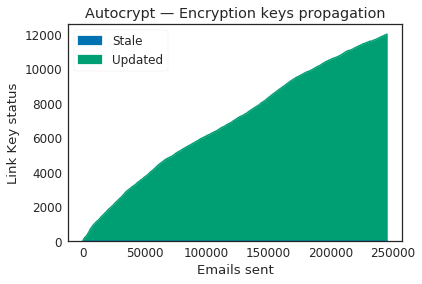

In [16]:
visualize_propagation('Autocrypt', ac_hp)
plt.show()

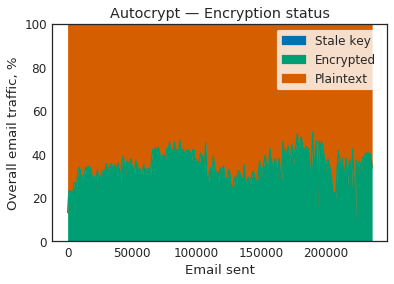

In [17]:
visualize_encryption_status_history('Autocrypt', ac_es)
plt.show()

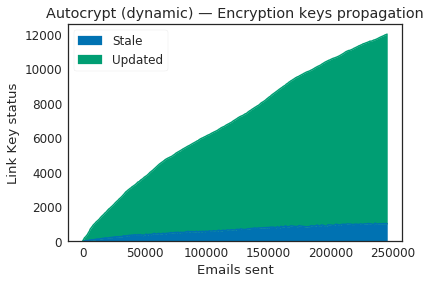

In [18]:
visualize_propagation('Autocrypt (dynamic)', dyn_ac_hp)
plt.show()

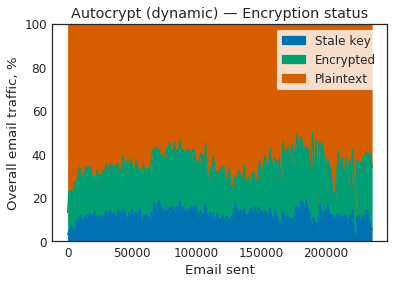

In [19]:
visualize_encryption_status_history('Autocrypt (dynamic)', dyn_ac_es)
plt.show()

## Public Claimchain

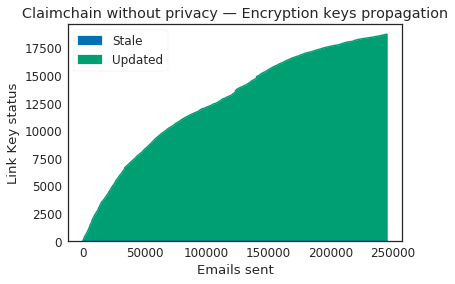

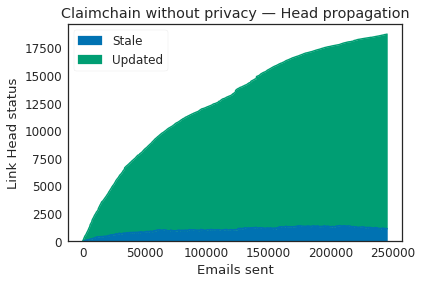

In [20]:
visualize_propagation('Claimchain without privacy', cc_pub_kp, cc_pub_hp)
plt.show()

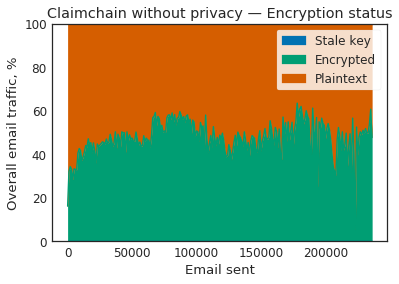

In [21]:
visualize_encryption_status_history('Claimchain without privacy', cc_pub_es)
plt.show()

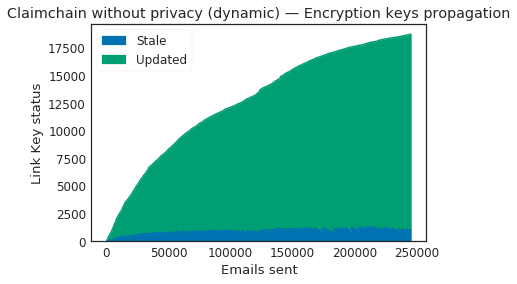

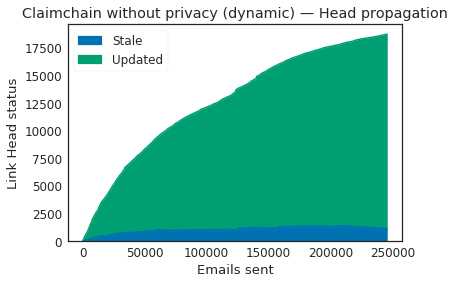

In [22]:
visualize_propagation('Claimchain without privacy (dynamic)', dyn_cc_pub_kp, dyn_cc_pub_hp)
plt.show()

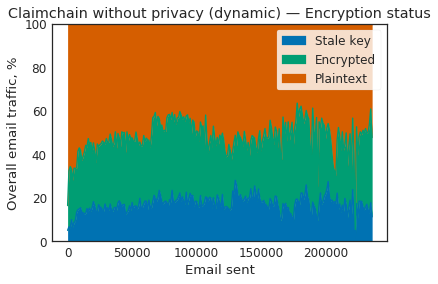

In [23]:
visualize_encryption_status_history('Claimchain without privacy (dynamic)', dyn_cc_pub_es)
plt.show()

## Claimchain with privacy

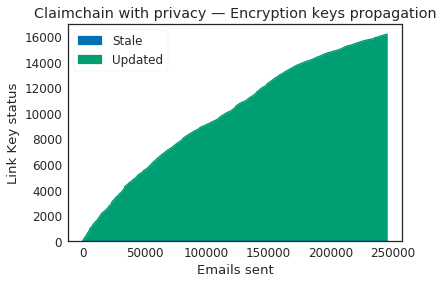

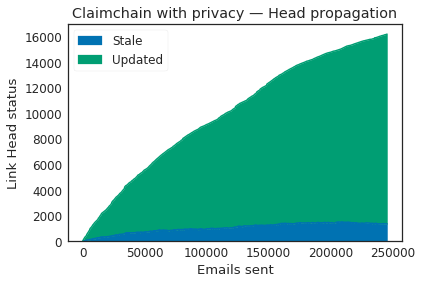

In [24]:
visualize_propagation('Claimchain with privacy', cc_priv_kp, cc_priv_hp)
plt.show()

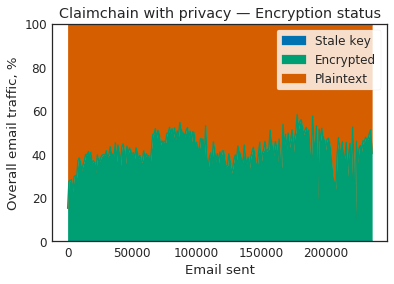

In [25]:
visualize_encryption_status_history('Claimchain with privacy', cc_priv_es)
plt.show()

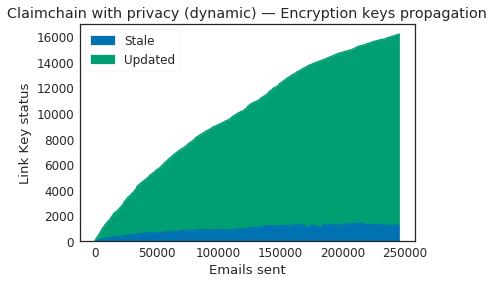

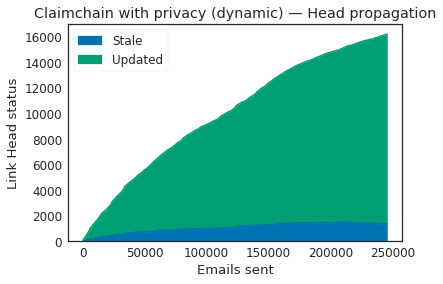

In [26]:
visualize_propagation('Claimchain with privacy (dynamic)', dyn_cc_priv_kp, dyn_cc_priv_hp)
plt.show()

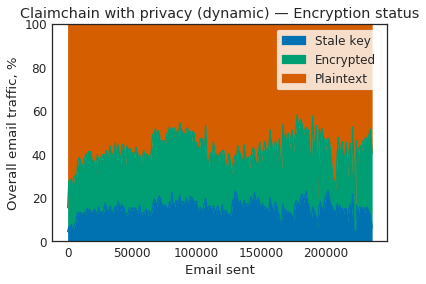

In [27]:
visualize_encryption_status_history('Claimchain with privacy (dynamic)', dyn_cc_priv_es)
plt.show()